# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "x_shape",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_1v2:oracle.run1.framed-oracle.run2.framed",
    "device": "cuda",
    "lr": 0.0001,
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": ["unit_power"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run1_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": ["unit_power"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run2_",
        },
    ],
    "dataset_seed": 1337,
    "seed": 1337,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

if "x_shape" not in p:
    p.x_shape = [2,256] # Default to this if we dont supply x_shape


supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")

In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'ORACLE.run1_44', 'ORACLE.run1_14', 'ORACLE.run1_50', 'ORACLE.run1_26', 'ORACLE.run1_8', 'ORACLE.run1_20', 'ORACLE.run1_38', 'ORACLE.run1_32'}


{'ORACLE.run2_14', 'ORACLE.run2_44', 'ORACLE.run2_38', 'ORACLE.run2_26', 'ORACLE.run2_20', 'ORACLE.run2_8', 'ORACLE.run2_50', 'ORACLE.run2_32'}


tensor([[[-0.0924,  1.1552, -0.1109,  ..., -0.9518, -0.2588, -0.5545],
         [-0.6376, -0.2957,  1.0535,  ...,  0.2403, -1.4139, -0.4713]],

        [[-0.4449,  0.6767,  0.5469,  ..., -1.2421, -1.1679, -0.1112],
         [-1.1216, -0.3152,  1.1030,  ...,  0.4078, -0.1483,  1.2050]],

        [[ 0.6507, -0.3532, -0.7623,  ...,  0.7901,  1.3665,  0.3254],
         [ 0.8273,  0.6786, -0.8831,  ..., -0.7530,  0.4648, -1.1527]],

        ...,

        [[ 0.9828, -0.2394, -1.1718,  ...,  0.6363,  0.9828, -0.6489],
         [ 0.5544,  0.7119, -0.3717,  ..., -0.9702, -0.6111, -1.1214]],

        [[ 0.0252, -0.9847,  0.2840,  ...,  0.8963,  0.4671,  1.0667],
         [ 0.7890,  0.4229, -1.1298,  ..., -0.1199,  1.2624, -0.2272]],

        [[ 0.4796,  0.3281, -0.7194,  ..., -0.4544,  1.2306,  1.0223],
         [-0.4102,  1.1043, -0.0316,  ..., -1.0728, -0.0568, -0.2461]]])


In [21]:
###################################
# Build the model
###################################
# easfsl only wants a tuple for the shape
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=tuple(p.x_shape))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 6720], examples_per_second: 32.1853, train_label_loss: 2.9737, 


epoch: 1, [batch: 672 / 6720], examples_per_second: 3346.6653, train_label_loss: 1.3705, 


epoch: 1, [batch: 1344 / 6720], examples_per_second: 3000.0684, train_label_loss: 0.6519, 


epoch: 1, [batch: 2016 / 6720], examples_per_second: 3001.0816, train_label_loss: 0.6388, 


epoch: 1, [batch: 2688 / 6720], examples_per_second: 2923.9189, train_label_loss: 0.8008, 


epoch: 1, [batch: 3360 / 6720], examples_per_second: 2420.4912, train_label_loss: 0.8381, 


epoch: 1, [batch: 4032 / 6720], examples_per_second: 2360.2928, train_label_loss: 0.5642, 


epoch: 1, [batch: 4704 / 6720], examples_per_second: 2321.3080, train_label_loss: 0.3418, 


epoch: 1, [batch: 5376 / 6720], examples_per_second: 2352.7435, train_label_loss: 0.6847, 


epoch: 1, [batch: 6048 / 6720], examples_per_second: 2556.8009, train_label_loss: 0.4238, 


epoch: 1, source_val_acc_label: 0.6687, target_val_acc_label: 0.6628, source_val_label_loss: 31.3708, target_val_label_loss: 32.3150, 


New best


epoch: 2, [batch: 1 / 6720], examples_per_second: 2.4780, train_label_loss: 24.5370, 


epoch: 2, [batch: 672 / 6720], examples_per_second: 2729.1451, train_label_loss: 0.6052, 


epoch: 2, [batch: 1344 / 6720], examples_per_second: 2577.7853, train_label_loss: 0.3991, 


epoch: 2, [batch: 2016 / 6720], examples_per_second: 2600.9173, train_label_loss: 1.0733, 


epoch: 2, [batch: 2688 / 6720], examples_per_second: 2699.0926, train_label_loss: 0.7240, 


epoch: 2, [batch: 3360 / 6720], examples_per_second: 2695.9956, train_label_loss: 0.4031, 


epoch: 2, [batch: 4032 / 6720], examples_per_second: 2649.0322, train_label_loss: 0.8458, 


epoch: 2, [batch: 4704 / 6720], examples_per_second: 2581.0429, train_label_loss: 0.5968, 


epoch: 2, [batch: 5376 / 6720], examples_per_second: 2983.6886, train_label_loss: 0.6397, 


epoch: 2, [batch: 6048 / 6720], examples_per_second: 2862.5368, train_label_loss: 0.4534, 


epoch: 2, source_val_acc_label: 0.7992, target_val_acc_label: 0.7944, source_val_label_loss: 0.5489, target_val_label_loss: 0.6007, 


New best


epoch: 3, [batch: 1 / 6720], examples_per_second: 2.3101, train_label_loss: 0.6888, 


epoch: 3, [batch: 672 / 6720], examples_per_second: 2965.7765, train_label_loss: 0.2027, 


epoch: 3, [batch: 1344 / 6720], examples_per_second: 2850.1201, train_label_loss: 0.3707, 


epoch: 3, [batch: 2016 / 6720], examples_per_second: 2821.0643, train_label_loss: 0.1958, 


epoch: 3, [batch: 2688 / 6720], examples_per_second: 2825.1331, train_label_loss: 0.3846, 


epoch: 3, [batch: 3360 / 6720], examples_per_second: 3035.0432, train_label_loss: 1.0251, 


epoch: 3, [batch: 4032 / 6720], examples_per_second: 2946.6829, train_label_loss: 0.5501, 


epoch: 3, [batch: 4704 / 6720], examples_per_second: 2743.8749, train_label_loss: 0.2123, 


epoch: 3, [batch: 5376 / 6720], examples_per_second: 3161.2235, train_label_loss: 0.3079, 


epoch: 3, [batch: 6048 / 6720], examples_per_second: 3219.2202, train_label_loss: 0.1517, 


epoch: 3, source_val_acc_label: 0.8458, target_val_acc_label: 0.8355, source_val_label_loss: 0.4280, target_val_label_loss: 0.4870, 


New best


epoch: 4, [batch: 1 / 6720], examples_per_second: 3.3875, train_label_loss: 0.2347, 


epoch: 4, [batch: 672 / 6720], examples_per_second: 3804.0957, train_label_loss: 0.1486, 


epoch: 4, [batch: 1344 / 6720], examples_per_second: 3809.7056, train_label_loss: 0.8034, 


epoch: 4, [batch: 2016 / 6720], examples_per_second: 4004.8226, train_label_loss: 0.6152, 


epoch: 4, [batch: 2688 / 6720], examples_per_second: 3906.6330, train_label_loss: 0.5013, 


epoch: 4, [batch: 3360 / 6720], examples_per_second: 3536.9165, train_label_loss: 0.2682, 


epoch: 4, [batch: 4032 / 6720], examples_per_second: 3176.9505, train_label_loss: 0.6595, 


epoch: 4, [batch: 4704 / 6720], examples_per_second: 2887.0236, train_label_loss: 0.4421, 


epoch: 4, [batch: 5376 / 6720], examples_per_second: 2587.3106, train_label_loss: 0.2826, 


epoch: 4, [batch: 6048 / 6720], examples_per_second: 2845.2463, train_label_loss: 0.3187, 


epoch: 4, source_val_acc_label: 0.8498, target_val_acc_label: 0.8335, source_val_label_loss: 0.4146, target_val_label_loss: 0.4999, 


epoch: 5, [batch: 1 / 6720], examples_per_second: 2.5523, train_label_loss: 0.1345, 


epoch: 5, [batch: 672 / 6720], examples_per_second: 2660.5884, train_label_loss: 0.1707, 


epoch: 5, [batch: 1344 / 6720], examples_per_second: 2955.6193, train_label_loss: 0.4789, 


epoch: 5, [batch: 2016 / 6720], examples_per_second: 2996.4966, train_label_loss: 0.6024, 


epoch: 5, [batch: 2688 / 6720], examples_per_second: 3449.7602, train_label_loss: 0.2807, 


epoch: 5, [batch: 3360 / 6720], examples_per_second: 3454.4071, train_label_loss: 0.0976, 


epoch: 5, [batch: 4032 / 6720], examples_per_second: 3104.1531, train_label_loss: 0.2367, 


epoch: 5, [batch: 4704 / 6720], examples_per_second: 2312.8419, train_label_loss: 0.1255, 


epoch: 5, [batch: 5376 / 6720], examples_per_second: 2496.5144, train_label_loss: 0.4833, 


epoch: 5, [batch: 6048 / 6720], examples_per_second: 2371.4439, train_label_loss: 0.2191, 


epoch: 5, source_val_acc_label: 0.8622, target_val_acc_label: 0.8486, source_val_label_loss: 0.3849, target_val_label_loss: 0.4595, 


New best


epoch: 6, [batch: 1 / 6720], examples_per_second: 2.3921, train_label_loss: 0.3296, 


epoch: 6, [batch: 672 / 6720], examples_per_second: 2914.9910, train_label_loss: 0.5889, 


epoch: 6, [batch: 1344 / 6720], examples_per_second: 2899.5699, train_label_loss: 0.4667, 


epoch: 6, [batch: 2016 / 6720], examples_per_second: 3612.9907, train_label_loss: 0.1172, 


epoch: 6, [batch: 2688 / 6720], examples_per_second: 3928.8548, train_label_loss: 0.0741, 


epoch: 6, [batch: 3360 / 6720], examples_per_second: 2908.3096, train_label_loss: 0.1806, 


epoch: 6, [batch: 4032 / 6720], examples_per_second: 2330.5388, train_label_loss: 0.4615, 


epoch: 6, [batch: 4704 / 6720], examples_per_second: 2504.3240, train_label_loss: 0.3955, 


epoch: 6, [batch: 5376 / 6720], examples_per_second: 2344.7337, train_label_loss: 0.3707, 


epoch: 6, [batch: 6048 / 6720], examples_per_second: 2428.7902, train_label_loss: 0.1388, 


epoch: 6, source_val_acc_label: 0.8814, target_val_acc_label: 0.8650, source_val_label_loss: 0.3268, target_val_label_loss: 0.4236, 


New best


epoch: 7, [batch: 1 / 6720], examples_per_second: 2.1936, train_label_loss: 0.0750, 


epoch: 7, [batch: 672 / 6720], examples_per_second: 2807.3075, train_label_loss: 0.4636, 


epoch: 7, [batch: 1344 / 6720], examples_per_second: 3663.3982, train_label_loss: 0.1798, 


epoch: 7, [batch: 2016 / 6720], examples_per_second: 3810.3967, train_label_loss: 0.3048, 


epoch: 7, [batch: 2688 / 6720], examples_per_second: 3451.6530, train_label_loss: 0.5140, 


epoch: 7, [batch: 3360 / 6720], examples_per_second: 3382.7081, train_label_loss: 0.7919, 


epoch: 7, [batch: 4032 / 6720], examples_per_second: 3367.6595, train_label_loss: 0.1454, 


epoch: 7, [batch: 4704 / 6720], examples_per_second: 3009.6823, train_label_loss: 0.3021, 


epoch: 7, [batch: 5376 / 6720], examples_per_second: 2341.4032, train_label_loss: 0.1171, 


epoch: 7, [batch: 6048 / 6720], examples_per_second: 2358.0671, train_label_loss: 0.1785, 


epoch: 7, source_val_acc_label: 0.8703, target_val_acc_label: 0.8499, source_val_label_loss: 0.3529, target_val_label_loss: 0.4523, 


epoch: 8, [batch: 1 / 6720], examples_per_second: 2.1215, train_label_loss: 0.3725, 


epoch: 8, [batch: 672 / 6720], examples_per_second: 2621.9989, train_label_loss: 0.4671, 


epoch: 8, [batch: 1344 / 6720], examples_per_second: 2634.0829, train_label_loss: 0.4314, 


epoch: 8, [batch: 2016 / 6720], examples_per_second: 2678.2054, train_label_loss: 0.1543, 


epoch: 8, [batch: 2688 / 6720], examples_per_second: 2416.0868, train_label_loss: 0.0271, 


epoch: 8, [batch: 3360 / 6720], examples_per_second: 2612.4158, train_label_loss: 0.4238, 


epoch: 8, [batch: 4032 / 6720], examples_per_second: 2625.6259, train_label_loss: 0.4087, 


epoch: 8, [batch: 4704 / 6720], examples_per_second: 2753.7717, train_label_loss: 0.2722, 


epoch: 8, [batch: 5376 / 6720], examples_per_second: 2958.8318, train_label_loss: 0.2466, 


epoch: 8, [batch: 6048 / 6720], examples_per_second: 2965.2837, train_label_loss: 0.2236, 


epoch: 8, source_val_acc_label: 0.8931, target_val_acc_label: 0.8705, source_val_label_loss: 0.2980, target_val_label_loss: 0.3979, 


New best


epoch: 9, [batch: 1 / 6720], examples_per_second: 3.1331, train_label_loss: 0.1320, 


epoch: 9, [batch: 672 / 6720], examples_per_second: 3415.2627, train_label_loss: 0.4305, 


epoch: 9, [batch: 1344 / 6720], examples_per_second: 3337.7846, train_label_loss: 0.3806, 


epoch: 9, [batch: 2016 / 6720], examples_per_second: 2690.9257, train_label_loss: 0.2365, 


epoch: 9, [batch: 2688 / 6720], examples_per_second: 2317.0860, train_label_loss: 0.1701, 


epoch: 9, [batch: 3360 / 6720], examples_per_second: 2334.8432, train_label_loss: 0.3771, 


epoch: 9, [batch: 4032 / 6720], examples_per_second: 2300.7239, train_label_loss: 0.4281, 


epoch: 9, [batch: 4704 / 6720], examples_per_second: 2502.9577, train_label_loss: 0.1717, 


epoch: 9, [batch: 5376 / 6720], examples_per_second: 2405.5079, train_label_loss: 0.1616, 


epoch: 9, [batch: 6048 / 6720], examples_per_second: 2520.4428, train_label_loss: 0.0628, 


epoch: 9, source_val_acc_label: 0.8977, target_val_acc_label: 0.8727, source_val_label_loss: 0.2872, target_val_label_loss: 0.4069, 


New best


epoch: 10, [batch: 1 / 6720], examples_per_second: 2.5184, train_label_loss: 0.2472, 


epoch: 10, [batch: 672 / 6720], examples_per_second: 2782.4201, train_label_loss: 0.0964, 


epoch: 10, [batch: 1344 / 6720], examples_per_second: 2580.6675, train_label_loss: 0.3156, 


epoch: 10, [batch: 2016 / 6720], examples_per_second: 2861.2315, train_label_loss: 0.2760, 


epoch: 10, [batch: 2688 / 6720], examples_per_second: 2602.9441, train_label_loss: 0.2466, 


epoch: 10, [batch: 3360 / 6720], examples_per_second: 2590.2642, train_label_loss: 0.1515, 


epoch: 10, [batch: 4032 / 6720], examples_per_second: 2693.4359, train_label_loss: 0.1730, 


epoch: 10, [batch: 4704 / 6720], examples_per_second: 2955.3025, train_label_loss: 0.2459, 


epoch: 10, [batch: 5376 / 6720], examples_per_second: 2893.4194, train_label_loss: 0.2155, 


epoch: 10, [batch: 6048 / 6720], examples_per_second: 2340.8530, train_label_loss: 0.0257, 


epoch: 10, source_val_acc_label: 0.9007, target_val_acc_label: 0.8759, source_val_label_loss: 0.2792, target_val_label_loss: 0.3991, 


New best


epoch: 11, [batch: 1 / 6720], examples_per_second: 2.2979, train_label_loss: 0.3376, 


epoch: 11, [batch: 672 / 6720], examples_per_second: 2540.6122, train_label_loss: 0.0798, 


epoch: 11, [batch: 1344 / 6720], examples_per_second: 2574.5452, train_label_loss: 0.3132, 


epoch: 11, [batch: 2016 / 6720], examples_per_second: 2603.1801, train_label_loss: 0.2214, 


epoch: 11, [batch: 2688 / 6720], examples_per_second: 2794.6788, train_label_loss: 0.6196, 


epoch: 11, [batch: 3360 / 6720], examples_per_second: 2661.2448, train_label_loss: 0.2078, 


epoch: 11, [batch: 4032 / 6720], examples_per_second: 2548.6719, train_label_loss: 0.2107, 


epoch: 11, [batch: 4704 / 6720], examples_per_second: 2606.4836, train_label_loss: 0.0237, 


epoch: 11, [batch: 5376 / 6720], examples_per_second: 2343.7874, train_label_loss: 0.2550, 


epoch: 11, [batch: 6048 / 6720], examples_per_second: 2590.3744, train_label_loss: 0.1715, 


epoch: 11, source_val_acc_label: 0.8991, target_val_acc_label: 0.8741, source_val_label_loss: 0.2818, target_val_label_loss: 0.5462, 


epoch: 12, [batch: 1 / 6720], examples_per_second: 2.8428, train_label_loss: 0.3688, 


epoch: 12, [batch: 672 / 6720], examples_per_second: 2943.7693, train_label_loss: 0.3299, 


epoch: 12, [batch: 1344 / 6720], examples_per_second: 3035.7900, train_label_loss: 0.0997, 


epoch: 12, [batch: 2016 / 6720], examples_per_second: 2988.1900, train_label_loss: 0.2507, 


epoch: 12, [batch: 2688 / 6720], examples_per_second: 2567.9532, train_label_loss: 0.0733, 


epoch: 12, [batch: 3360 / 6720], examples_per_second: 2714.3357, train_label_loss: 0.2421, 


epoch: 12, [batch: 4032 / 6720], examples_per_second: 2811.0294, train_label_loss: 0.3399, 


epoch: 12, [batch: 4704 / 6720], examples_per_second: 2615.6883, train_label_loss: 0.2716, 


epoch: 12, [batch: 5376 / 6720], examples_per_second: 2845.4755, train_label_loss: 0.0642, 


epoch: 12, [batch: 6048 / 6720], examples_per_second: 2706.6491, train_label_loss: 0.1482, 


epoch: 12, source_val_acc_label: 0.9051, target_val_acc_label: 0.8796, source_val_label_loss: 0.2670, target_val_label_loss: 0.5310, 


New best


epoch: 13, [batch: 1 / 6720], examples_per_second: 3.0324, train_label_loss: 0.3559, 


epoch: 13, [batch: 672 / 6720], examples_per_second: 3306.4518, train_label_loss: 0.2495, 


epoch: 13, [batch: 1344 / 6720], examples_per_second: 3425.3095, train_label_loss: 0.0999, 


epoch: 13, [batch: 2016 / 6720], examples_per_second: 3389.0012, train_label_loss: 0.1926, 


epoch: 13, [batch: 2688 / 6720], examples_per_second: 3268.3719, train_label_loss: 0.0408, 


epoch: 13, [batch: 3360 / 6720], examples_per_second: 2933.0999, train_label_loss: 0.3443, 


epoch: 13, [batch: 4032 / 6720], examples_per_second: 2624.8974, train_label_loss: 0.2647, 


epoch: 13, [batch: 4704 / 6720], examples_per_second: 3170.2568, train_label_loss: 0.0124, 


epoch: 13, [batch: 5376 / 6720], examples_per_second: 2917.3626, train_label_loss: 0.1005, 


epoch: 13, [batch: 6048 / 6720], examples_per_second: 3549.3440, train_label_loss: 0.1374, 


epoch: 13, source_val_acc_label: 0.9012, target_val_acc_label: 0.8782, source_val_label_loss: 0.2774, target_val_label_loss: 0.7076, 


epoch: 14, [batch: 1 / 6720], examples_per_second: 3.4526, train_label_loss: 0.2128, 


epoch: 14, [batch: 672 / 6720], examples_per_second: 4087.5551, train_label_loss: 0.1613, 


epoch: 14, [batch: 1344 / 6720], examples_per_second: 4458.6636, train_label_loss: 0.1095, 


epoch: 14, [batch: 2016 / 6720], examples_per_second: 3348.6453, train_label_loss: 0.1822, 


epoch: 14, [batch: 2688 / 6720], examples_per_second: 2582.8284, train_label_loss: 0.1374, 


epoch: 14, [batch: 3360 / 6720], examples_per_second: 2769.6809, train_label_loss: 0.0867, 


epoch: 14, [batch: 4032 / 6720], examples_per_second: 2717.3016, train_label_loss: 0.3481, 


epoch: 14, [batch: 4704 / 6720], examples_per_second: 2654.2883, train_label_loss: 0.1741, 


epoch: 14, [batch: 5376 / 6720], examples_per_second: 2775.5900, train_label_loss: 0.1307, 


epoch: 14, [batch: 6048 / 6720], examples_per_second: 2690.5205, train_label_loss: 0.0180, 


epoch: 14, source_val_acc_label: 0.9093, target_val_acc_label: 0.8838, source_val_label_loss: 0.2558, target_val_label_loss: 0.6442, 


New best


epoch: 15, [batch: 1 / 6720], examples_per_second: 2.7297, train_label_loss: 0.0788, 


epoch: 15, [batch: 672 / 6720], examples_per_second: 3779.5286, train_label_loss: 0.0613, 


epoch: 15, [batch: 1344 / 6720], examples_per_second: 3552.5603, train_label_loss: 0.0477, 


epoch: 15, [batch: 2016 / 6720], examples_per_second: 3421.3032, train_label_loss: 0.1470, 


epoch: 15, [batch: 2688 / 6720], examples_per_second: 3428.3743, train_label_loss: 0.2205, 


epoch: 15, [batch: 3360 / 6720], examples_per_second: 3044.1260, train_label_loss: 0.1475, 


epoch: 15, [batch: 4032 / 6720], examples_per_second: 2602.6798, train_label_loss: 0.1289, 


epoch: 15, [batch: 4704 / 6720], examples_per_second: 2562.1020, train_label_loss: 0.2748, 


epoch: 15, [batch: 5376 / 6720], examples_per_second: 2558.3165, train_label_loss: 0.0194, 


epoch: 15, [batch: 6048 / 6720], examples_per_second: 2794.7383, train_label_loss: 0.1561, 


epoch: 15, source_val_acc_label: 0.9022, target_val_acc_label: 0.8741, source_val_label_loss: 0.2763, target_val_label_loss: 0.9112, 


epoch: 16, [batch: 1 / 6720], examples_per_second: 2.4950, train_label_loss: 0.1004, 


epoch: 16, [batch: 672 / 6720], examples_per_second: 3048.0916, train_label_loss: 0.0425, 


epoch: 16, [batch: 1344 / 6720], examples_per_second: 2719.5949, train_label_loss: 0.0987, 


epoch: 16, [batch: 2016 / 6720], examples_per_second: 2826.1740, train_label_loss: 0.0196, 


epoch: 16, [batch: 2688 / 6720], examples_per_second: 2915.0255, train_label_loss: 0.1939, 


epoch: 16, [batch: 3360 / 6720], examples_per_second: 3347.3678, train_label_loss: 0.2082, 


epoch: 16, [batch: 4032 / 6720], examples_per_second: 3444.5905, train_label_loss: 0.4936, 


epoch: 16, [batch: 4704 / 6720], examples_per_second: 3278.6550, train_label_loss: 0.1093, 


epoch: 16, [batch: 5376 / 6720], examples_per_second: 3866.8889, train_label_loss: 0.1085, 


epoch: 16, [batch: 6048 / 6720], examples_per_second: 3741.7452, train_label_loss: 0.0984, 


epoch: 16, source_val_acc_label: 0.9012, target_val_acc_label: 0.8740, source_val_label_loss: 0.2853, target_val_label_loss: 0.9595, 


epoch: 17, [batch: 1 / 6720], examples_per_second: 4.4283, train_label_loss: 0.0414, 


epoch: 17, [batch: 672 / 6720], examples_per_second: 3778.6677, train_label_loss: 0.2736, 


epoch: 17, [batch: 1344 / 6720], examples_per_second: 3103.6694, train_label_loss: 0.0757, 


epoch: 17, [batch: 2016 / 6720], examples_per_second: 2827.5142, train_label_loss: 0.2837, 


epoch: 17, [batch: 2688 / 6720], examples_per_second: 2804.9632, train_label_loss: 0.1687, 


epoch: 17, [batch: 3360 / 6720], examples_per_second: 3126.7980, train_label_loss: 0.2569, 


epoch: 17, [batch: 4032 / 6720], examples_per_second: 3124.5812, train_label_loss: 0.2822, 


epoch: 17, [batch: 4704 / 6720], examples_per_second: 2839.8790, train_label_loss: 0.0800, 


epoch: 17, [batch: 5376 / 6720], examples_per_second: 2937.2160, train_label_loss: 0.1716, 


epoch: 17, [batch: 6048 / 6720], examples_per_second: 3190.5762, train_label_loss: 0.0553, 


epoch: 17, source_val_acc_label: 0.9098, target_val_acc_label: 0.8793, source_val_label_loss: 0.2634, target_val_label_loss: 1.3058, 


epoch: 18, [batch: 1 / 6720], examples_per_second: 3.1040, train_label_loss: 0.0461, 


epoch: 18, [batch: 672 / 6720], examples_per_second: 3289.8062, train_label_loss: 0.0721, 


epoch: 18, [batch: 1344 / 6720], examples_per_second: 3480.4734, train_label_loss: 0.1152, 


epoch: 18, [batch: 2016 / 6720], examples_per_second: 3323.7701, train_label_loss: 0.1252, 


epoch: 18, [batch: 2688 / 6720], examples_per_second: 3917.4798, train_label_loss: 0.3079, 


epoch: 18, [batch: 3360 / 6720], examples_per_second: 3853.0746, train_label_loss: 0.0905, 


epoch: 18, [batch: 4032 / 6720], examples_per_second: 3216.9561, train_label_loss: 0.0049, 


epoch: 18, [batch: 4704 / 6720], examples_per_second: 2335.8459, train_label_loss: 0.0407, 


epoch: 18, [batch: 5376 / 6720], examples_per_second: 2270.3021, train_label_loss: 0.0734, 


epoch: 18, [batch: 6048 / 6720], examples_per_second: 2505.5899, train_label_loss: 0.2799, 


epoch: 18, source_val_acc_label: 0.9029, target_val_acc_label: 0.8791, source_val_label_loss: 0.2860, target_val_label_loss: 1.3215, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

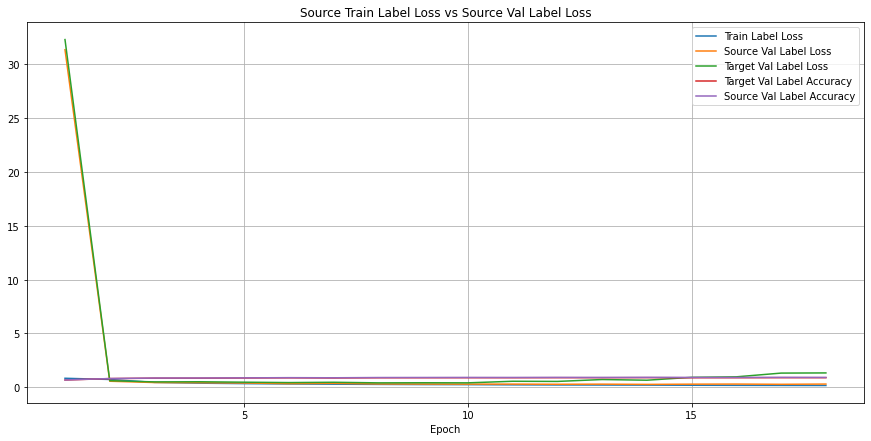

In [25]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

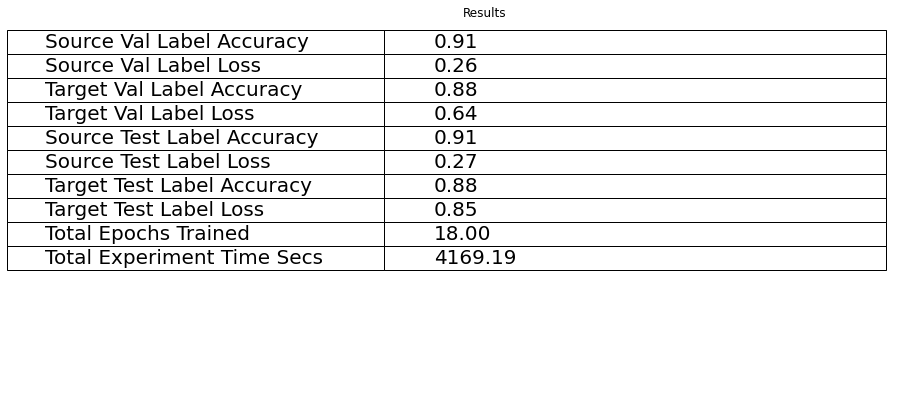

In [26]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

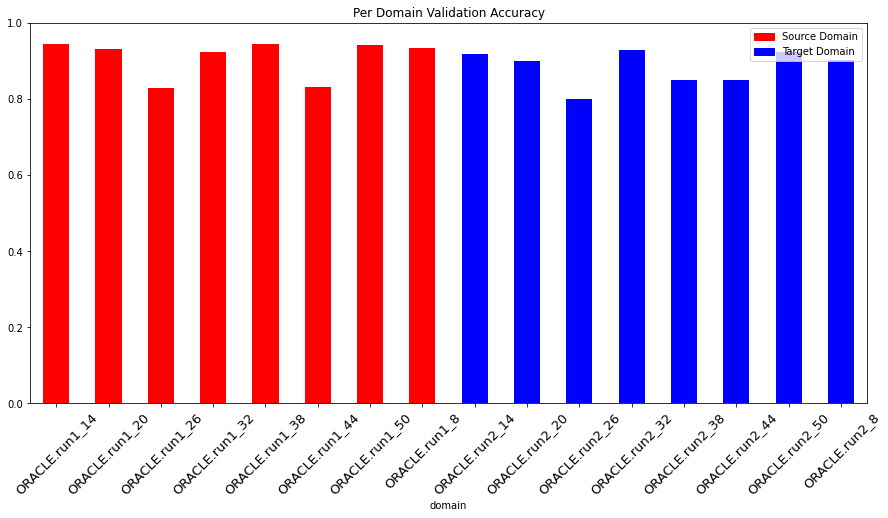

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9107096354166667 Target Test Label Accuracy: 0.8849609375
Source Val Label Accuracy: 0.90927734375 Target Val Label Accuracy: 0.8838216145833333


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_1v2:oracle.run1.framed-oracle.run2.framed", "parameters": {"experiment_name": "tl_1v2:oracle.run1.framed-oracle.run2.framed", "device": "cuda", "lr": 0.0001, "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_features": 2048